## Converting The Sensor Data to Magnetometer Readings

The raw sensor data consists of 3 values; a timestamp, a number between 0 and 65534 representing a frequency and the temperature reading. There are several steps involved in converting these sensor readings into magnetometer variameter data, which this notebook goes through.

In [1]:
# Import the required libraries.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn import mixture
from datetime import datetime, timedelta

from cpdetect import cpDetector

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

from pymongo import MongoClient
import mongo_cursors

/home/james/anaconda3/envs/anacenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/james/anaconda3/envs/anacenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/james/anaconda3/envs/anacenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/james/anaconda3/envs/anacenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load the data into a pandas dataframe.

In [2]:
# ##  Uncomment this cell to load data from CSV's  ###
# dat_fp = "../mag_data_copy/"
# years = ["2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]

# mag_dat = {}
# for year in years:
#     mag_dat[year] = pd.read_csv(dat_fp+year+"_mag_dat.csv",
#                                 dtype={"time": np.object_,
#                                        "reading": np.float64,
#                                        "temperature": np.float64})
#     mag_dat[year]["time"] = pd.to_datetime(mag_dat[year]["time"],format="%Y-%m-%d %H:%M:%S")
# all_mag_dat = pd.concat(mag_dat.values())
# del mag_dat

In [3]:
read_cursor = mongo_cursors.get_read_cursor()
all_sensordat = read_cursor.sensorDat.find({ "$and": [ {"reading": {"$gte": 0}},
                                                       {"reading": {"$lte": 65534}},
                                                     ]
                                           },
                                           {"_id": 0}).sort([("time", 1)])
all_mag_dat = pd.DataFrame(list(all_sensordat))
all_mag_dat.drop(columns="sensor_id", inplace=True)
all_mag_dat.set_index("time", inplace=True)
print("Dataframe size:", all_mag_dat.shape)
all_mag_dat.dropna(inplace=True)
all_mag_dat.head()

Dataframe size: (31087585, 2)


,reading,temperature
time,,
2011-02-02 12:02:50,29506.0,20.228
2011-02-02 12:02:53,29507.0,20.215
2011-02-02 12:02:56,29506.0,20.234
2011-02-02 12:02:59,29506.0,20.228
2011-02-02 12:03:02,29507.0,20.224


### Resampling the data.
The raw data is quite noisy and takes a lot of memory. Both of these problems can be solved by downsampling the data to 1 sample per minute. The data is also downsampled at 1 sample per hour, for detecting "step changes" in the data.

Note: when doing a mean resample using pandas, the resampled minute at a given time is all the times from that minute up to (but not including) the minute after. E.g. a minute resample at t=10:22 is the average of all the times $$10:22 \le t \lt 10:23$$ (see [pandas resampling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html).)

In [4]:
mag_dat_1h = all_mag_dat.resample('1h').mean()
mag_dat_1h.dropna(inplace=True)
all_mag_dat = all_mag_dat.resample('1T').mean()
all_mag_dat.dropna(inplace=True)

In [5]:
# Get info about the data sampled every 1 hour.
def get_df_info(df):
    df.info(memory_usage="deep")
    for dtype in [np.float64,'datetime64']:
        selected_dtype = df.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

get_df_info(mag_dat_1h)
print()
get_df_info(all_mag_dat)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25938 entries, 2011-02-02 12:00:00 to 2018-06-30 23:00:00
Data columns (total 2 columns):
reading        25938 non-null float64
temperature    25938 non-null float64
dtypes: float64(2)
memory usage: 607.9 KB
Average memory usage for <class 'numpy.float64'> columns: 0.20 MB
Average memory usage for datetime64 columns: 0.20 MB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1552945 entries, 2011-02-02 12:02:00 to 2018-06-30 23:59:00
Data columns (total 2 columns):
reading        1552945 non-null float64
temperature    1552945 non-null float64
dtypes: float64(2)
memory usage: 35.5 MB
Average memory usage for <class 'numpy.float64'> columns: 11.85 MB
Average memory usage for datetime64 columns: 11.85 MB


### Plot the raw sensor data against time.

The raw sensor data plot shows significant gaps in the readings and large step changes. In its current form, it cannot be converted into magnetic field readings. First, the data needs to be separated where there are step changes and time discontinuities.

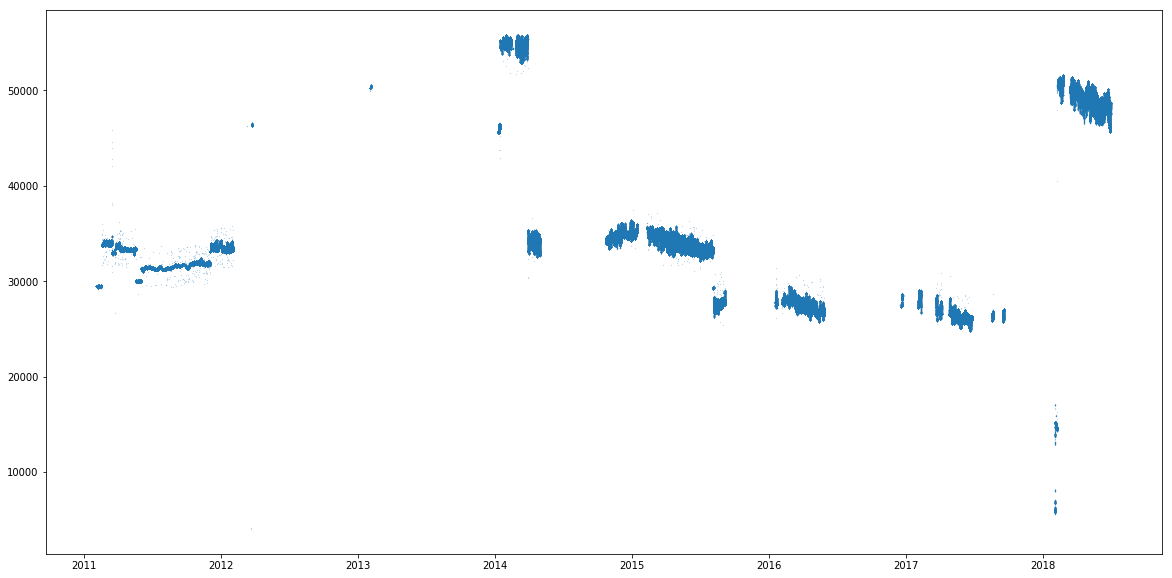

In [6]:
plt.figure(figsize=(20,10))
plt.plot(all_mag_dat["reading"], 'o', ms=0.1)

### Detecting step change points.
Step changes can be detected using bayesian changepoint detection. The Algorithm cannot handle large quantities of data, so the 1 hour-sapled data is used. (Note that this means the step detection accuracy is only every 1 hour, so some results will be corrupted by this.)

22:56:10 INFO cpDetector: =======================================
22:56:10 INFO cpDetector: Running change point detector
22:56:10 INFO cpDetector: =======================================
22:56:10 INFO cpDetector:    input observations: 1 of length [25938]
22:56:10 INFO cpDetector: Running cp detector on traj 0
22:56:10 INFO cpDetector: ---------------------------------
22:57:01 INFO cpDetector:     Found a new change point at: 8741!!
22:57:13 INFO cpDetector:     Found a new change point at: 7264!!
22:57:22 INFO cpDetector:     Found a new change point at: 2846!!
22:57:25 INFO cpDetector:     Found a new change point at: 325!!
22:57:29 INFO cpDetector:     Found a new change point at: 2512!!
22:57:31 INFO cpDetector:     Found a new change point at: 965!!
22:57:34 INFO cpDetector:     Found a new change point at: 1458!!
22:57:35 INFO cpDetector:     Found a new change point at: 1203!!
22:57:43 INFO cpDetector:     Found a new change point at: 4900!!
22:57:48 INFO cpDetector:     Found

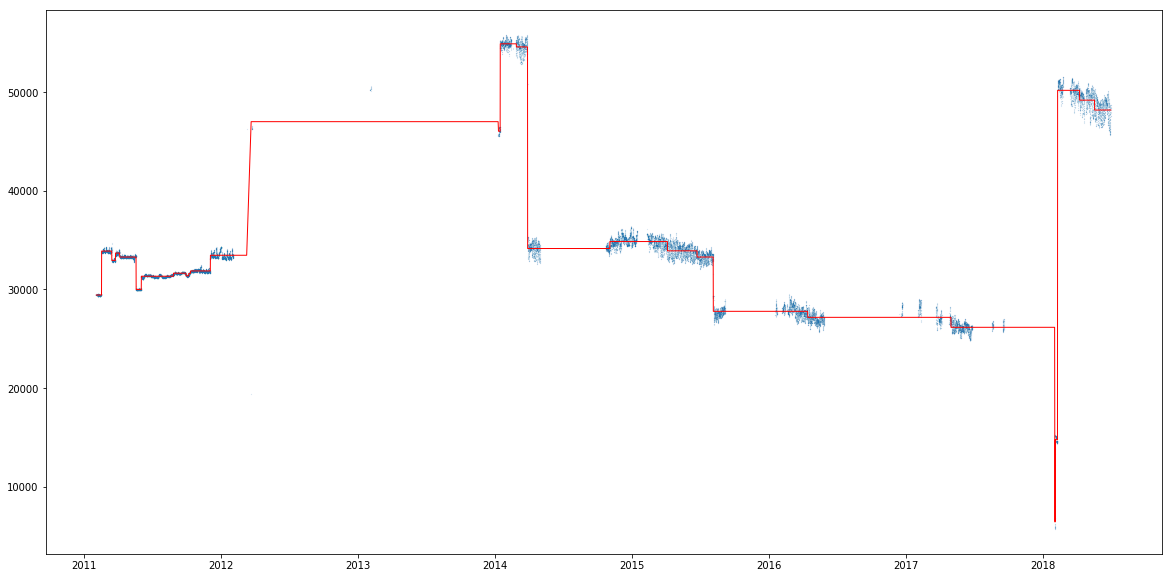

In [7]:
detector = cpDetector([mag_dat_1h["reading"]], distribution='log_normal', log_odds_threshold=50)
detector.detect_cp()
plt.figure(figsize=(20,10))
mag_dat_1h["cps"] = detector.step_function['traj_%s' % 0]
plt.plot(mag_dat_1h["reading"], 'o', alpha=0.6, ms=0.1)
plt.plot(mag_dat_1h["cps"], 'r', linewidth=1)

### Detecting time discontinuities.

This is considerably simpler to detect than step changes. Time discontinuities are found simply by "differencing" the times, and then
selecting the most significant differences. For now, any time greater than 1 day is considered a significant discontinuity.

The step change times and the time discontinuities are then combined into one array, by a union (in case there's a time discontinuity and a step change at the same time).

In [8]:
# Get the changepoint times.
cp_times = mag_dat_1h.index[detector.change_points["traj_0"].ts]
# set the minimum difference for a time discontinuity to be considered "significant". 
sig_diff = np.timedelta64(1, 'D')
# Select the times where there are significant discontinuities.
discs = all_mag_dat.dropna().index[np.append([False], np.diff(all_mag_dat.dropna().index) > sig_diff)]
# Combine the changepoint and discontinuity times using a union.
split_times = np.union1d(cp_times, discs)
# Sort the times.
split_times.sort()
# Append the very first time from all the magnetometer data and the very last time.
# This is so when performing calculations, the magnetometer data between the very
# start/ end and the first/ last changepoint/ discontinuity is included.
split_times = np.append([np.datetime64(all_mag_dat.index[0])], split_times)
split_times = np.append(split_times, [np.datetime64(all_mag_dat.index[-1])])
split_times

array(['2011-02-02T12:02:00.000000000', '2011-02-16T09:00:00.000000000',
       '2011-03-15T14:00:00.000000000', '2011-03-25T12:00:00.000000000',
       '2011-04-05T13:00:00.000000000', '2011-05-19T11:00:00.000000000',
       '2011-06-02T09:00:00.000000000', '2011-08-26T23:00:00.000000000',
       '2011-09-29T07:00:00.000000000', '2011-10-06T19:00:00.000000000',
       '2011-10-11T13:00:00.000000000', '2011-12-03T12:00:00.000000000',
       '2012-03-09T12:00:00.000000000', '2012-03-09T12:22:00.000000000',
       '2012-03-21T10:17:00.000000000', '2012-03-22T10:20:00.000000000',
       '2013-02-02T10:07:00.000000000', '2013-02-04T15:42:00.000000000',
       '2014-01-09T00:00:00.000000000', '2014-01-14T10:00:00.000000000',
       '2014-02-17T13:02:00.000000000', '2014-02-24T00:00:00.000000000',
       '2014-02-26T12:00:00.000000000', '2014-03-26T00:00:00.000000000',
       '2014-03-28T10:00:00.000000000', '2014-10-22T11:23:00.000000000',
       '2014-11-02T19:00:00.000000000', '2015-02-09

### Plot the same figure again, but this time with all the changepoints.

We can plot the data changepoint/ discontinuity intervals in different colours, to visualise where the changepoints are. This is done by looping through the changepoints, selecting data between current and "next" changepoint.

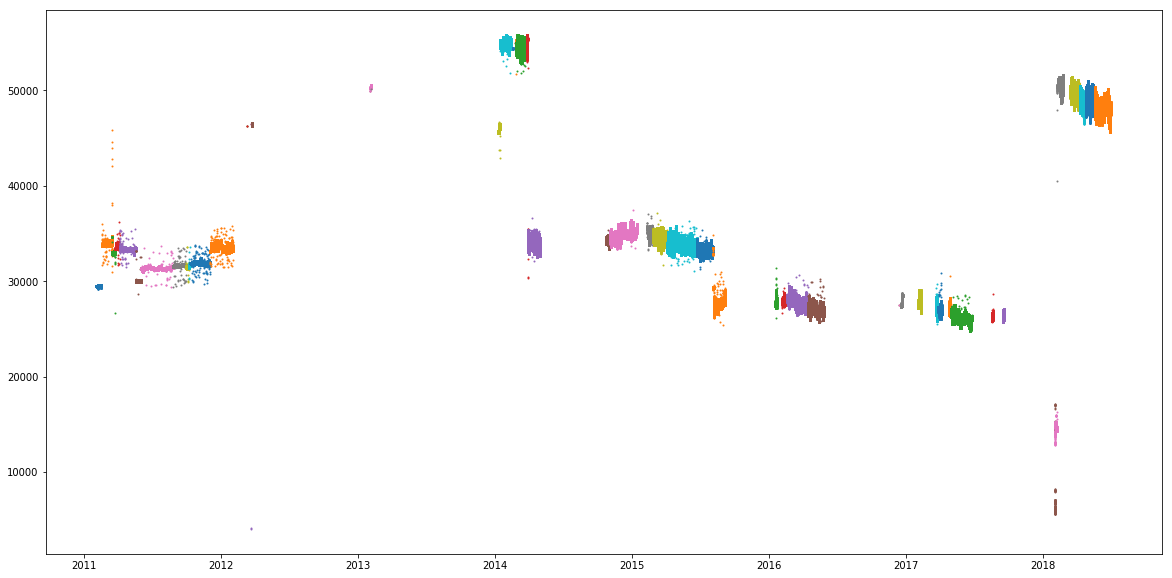

In [9]:
plt.figure(figsize=(20,10))

# Create a counter for iterating through the times where the data gets split.
# Subtract 1 from the total number of times because the time after the current
# time selected by the counter will be selected each iteration. If the last
# time was reached, an "IndexError" would be thrown, because there's no
# element after the last.
for i in range(split_times.shape[0] - 1):
    mag_dat_win = all_mag_dat.loc[split_times[i]:split_times[i+1]]
    plt.plot(mag_dat_win["reading"], 'o', ms=1)

### Calculating the magnetic field.
This step requires a number of sub-steps. The first step is to convert the magnetometer data into a period. When the sensor reading is 0, the frequency is 120kHz and when the reading is 65534, the frequency is 50kHz.
Therefore, the simultaneous equations are:

$$ 50000(Hz) = m \times 65534 + c $$
$$ 120000(Hz) = m \times 0 + c = c $$

Solving these gives:

$$ Frequency (Hz) =  ( \frac{70}{65534} \times reading + 120 ) \times 1000 $$

The period is then simply the inverse of frequency. However, the equation we will use to convert frequency to period will include a bias, because this is required for converting period to teslas[1].
So, to get the period, we use[1]:

$$ period = \frac{1}{freqency + bias} $$

Finally, to convert this period into a frequency, we use Timur Zagidulin's equation. The equation is a simple polynomial[1]:

$$ magneticfield(nT) = \alpha + \beta \times period + \gamma \times period^{2} + \delta \times period^{3} + \epsilon  \times period^{4} + \zeta  \times period^{5} $$

In [54]:
# Set the bias.
bias = 90000
# Calculate the period.
all_mag_dat["period"] = np.power(((-all_mag_dat["reading"]*70/65534+120)*1000+bias), -1)
# Create a place to store the "corrected" temperature.
all_mag_dat["temp_corr"] = all_mag_dat.loc[:, "temperature"]
# create places to store the period with the temperature correction and the magnetic field.
all_mag_dat["period_temp_corr"] = np.nan
all_mag_dat["mag_field"] = np.nan

Get the mean of all the coefficients from Timur's experiment and use these to calculate the magnetic field from our sensor. The function for calculating the magnetic field using the coefficients is also provided.

In [55]:
# Coefficients for the formula to convert period to magnetic field, from [1].
coefs = np.vstack(([ 7.75627250e+06, -5.60893614e+06, 1.61438337e+06, -2.30773456e+05,
                    1.64006851e+04, -4.67419417e+02],
                     [ 1.37845775e+07, -1.08586181e+07, 3.43274556e+06, -5.43192224e+05,
                      4.30466903e+04, -1.37019412e+03],
                     [ 9.93009467e+06, -7.05978073e+06, 1.98324201e+06, -2.74458051e+05,
                      1.87117495e+04, -5.06023333e+02])).mean(axis=0)

def mag_field(period_dat, coefs=coefs):
    return np.polynomial.polynomial.polyval(period_dat*1e6, coefs)

### Processing the raw data into magnetic field readings.

There are 3 processing steps needed to convert the sensor readings into data:
1. Correct the temperature.
2. Remove the temperature dependencies from readings.
3. Calculate the magnetic field variation from the data.

For some reason, the temperature readings "loop back" to $ 0^{\circ} C $ when the temperature exceeds about $ 30^{\circ} C $ (or the other way round, but it does not matter which way). This can be seen clearly in the figures generated 2 cells below. This looping can be detected using a Gaussian Mixture Model (an unsupervised, cluster classifier). Temperature and sensor reading are used as the inputs for this model. The data that is detected as having "looped" is coloured yellow, while the rest is labelled as purple. Temperatures detected as having "looped" are corrected by adding the maximum temperature to them.

The next step is to remove the temperature dependency from the sensor readings. The sensor-temperature relationship is assumed to be exponential due to a bipolar transistor, or:

$$ period \propto A e ^{a \times temperature}$$

By fitting this function to the temperature and period, and subtracting this function from the period, the temperature dependency can be removed.

The magnetic field is then calculated as explained above. Also, the "average" magnetic field is subtracted to remove the measured absolute magnetic field, because this will not be correct. The actual absolute magnetic field can be obtained using the variational magnetic field plus the field calculated using the IGRF model.

In [56]:
def exp_fun(x, A, a, c):
    return A*np.exp(a*x) + c


def corr_temp(mag_dat):
    X = np.column_stack((mag_dat["temperature"], mag_dat["period"]))
    gmm = mixture.GaussianMixture(n_components=2,
                                  covariance_type='full',
                                  means_init=((15, 0.000012), (0, 0.00001)),
                                 random_state=0).fit(X)

    temp_loopbacks = gmm.predict(X).astype(np.bool)
    mag_dat.loc[temp_loopbacks, "temp_corr"] += mag_dat["temperature"].max()
    return mag_dat["temp_corr"], temp_loopbacks


def corr_period_temp(mag_dat, fun=exp_fun):
    popt, pcov = curve_fit(fun, mag_dat["temp_corr"],
                     mag_dat["period"],
                     p0=(1e-7, -1e-2, 1e-6),
                     bounds=((0,-1e6,-1e6), (1e6, 0, 1e6)),
                     maxfev=10000)
    temp_period_fit = fun(mag_dat["temp_corr"], *popt)
    mag_dat["period_temp_corr"] = mag_dat["period"] - temp_period_fit + mag_dat["period"].mean()
    return popt, pcov, mag_dat["period_temp_corr"]


def plot_results(mag_dat, popt, temp_loopbacks, fun):
    temp_period_fit = fun(mag_dat["temp_corr"], *popt)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Temperature vs Period")
    ax[0].set_ylim((mag_dat["period"].min(), mag_dat["period"].max()))
    ax[0].scatter(mag_dat["temperature"], mag_dat["period"], c=temp_loopbacks, s=1)
    
    ax[1].set_title("Corrected Temperature vs Period")
    ax[1].set_ylim((mag_dat["period"].min(), mag_dat["period"].max()))
    ax[1].scatter(mag_dat["temp_corr"],mag_dat["period"], c=temp_loopbacks, s=1)
    mag_dat["temp_fit"] = fun(mag_dat["temp_corr"], *popt)
    mag_dat.sort_values("temp_corr", inplace=True)
    ax[1].plot(mag_dat["temp_corr"], mag_dat["temp_fit"])
    plt.show()
    mag_dat.drop("temp_fit", axis=1, inplace=True)
    
    
def get_mag_field(mag_dat, temp_fun=exp_fun, plots=True): 
    mag_dat["temp_corr"], temp_loopbacks = corr_temp(mag_dat)
    
    popt, pcov, mag_dat["period_temp_corr"] = corr_period_temp(mag_dat, temp_fun)
    print(popt)
    mag_dat["mag_field"] = mag_field(mag_dat["period_temp_corr"])
    mag_dat["mag_field"] -= mag_dat["mag_field"].mean()
    
    if plots:
        plot_results(mag_dat, popt, temp_loopbacks, temp_fun)
    
    return mag_dat

### Apply the conversion steps to each "window" between the discontinuities/ step changes in the data.

/home/james/anaconda3/envs/anacenv/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/james/anaconda3/envs/anacenv/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/james/anaconda3/envs/anacenv/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

[ 1.92355570e-07 -1.39920337e-01  5.58931346e-06]


/home/james/anaconda3/envs/anacenv/lib/python3.6/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/james/anaconda3/envs/anacenv/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


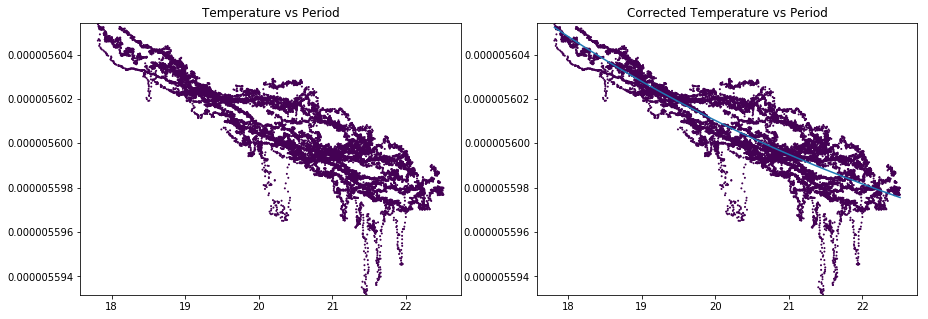

/home/james/anaconda3/envs/anacenv/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


[ 3.52063015e-07 -1.39055738e-01  5.73244894e-06]


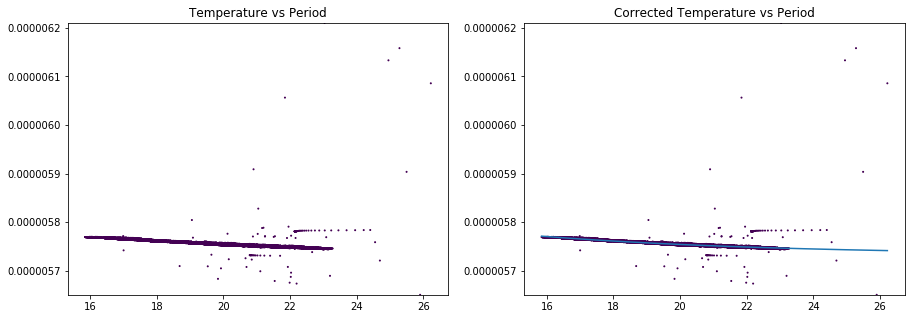

[ 1.76094408e-07 -2.69820389e-02  5.62213887e-06]


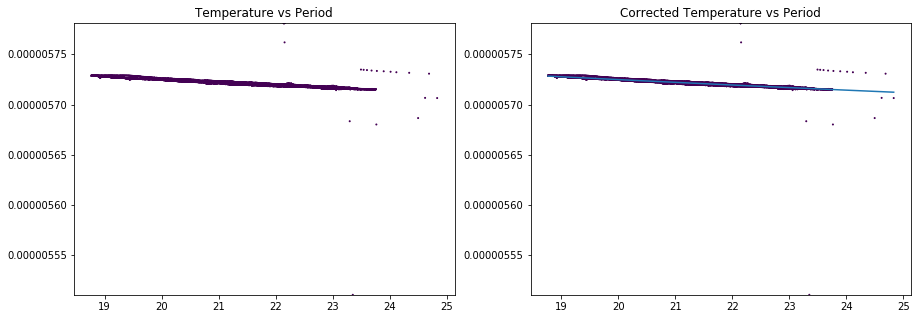

[ 5.01316314e-06 -7.83057203e-04  8.18449592e-07]


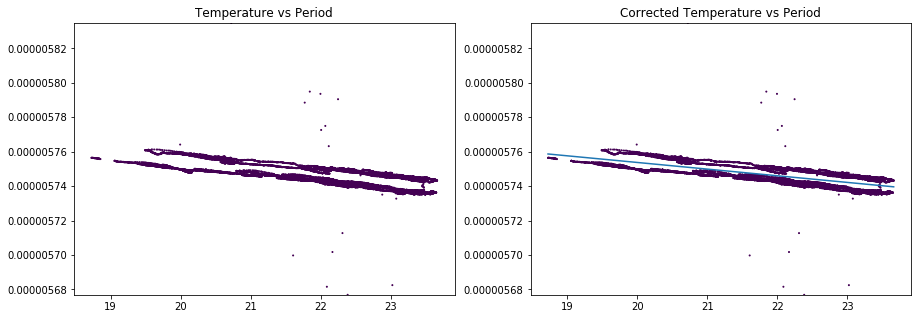

[ 1.33262052e-05 -2.17966015e-04 -7.52953583e-06]


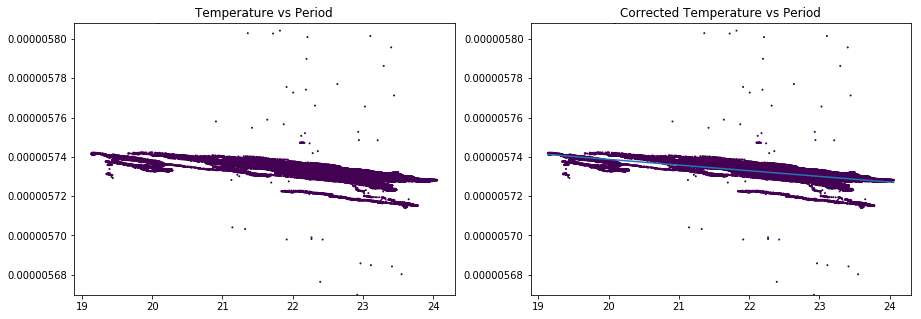

[ 8.24996941e-07 -2.15202832e-01  5.60523453e-06]


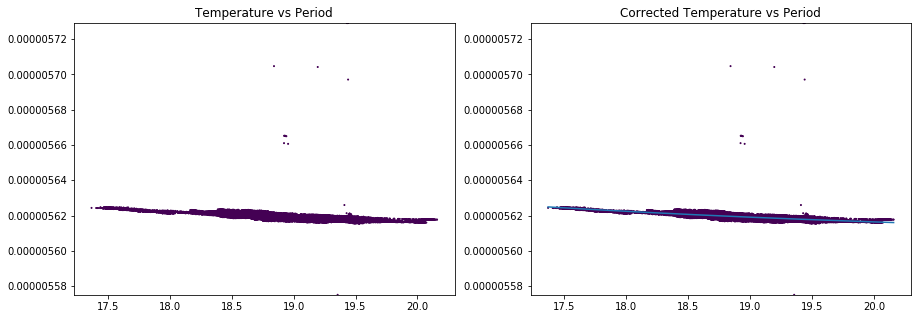

[ 1.28755586e-05 -2.11652704e-04 -7.15186623e-06]


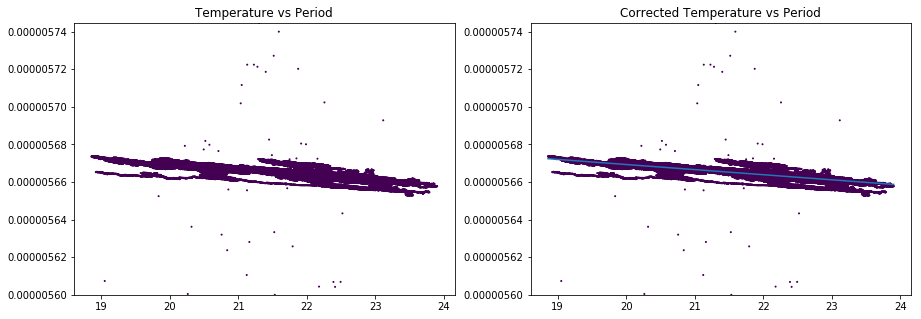

[ 1.78155004e-07 -5.97040864e-02  5.62194172e-06]


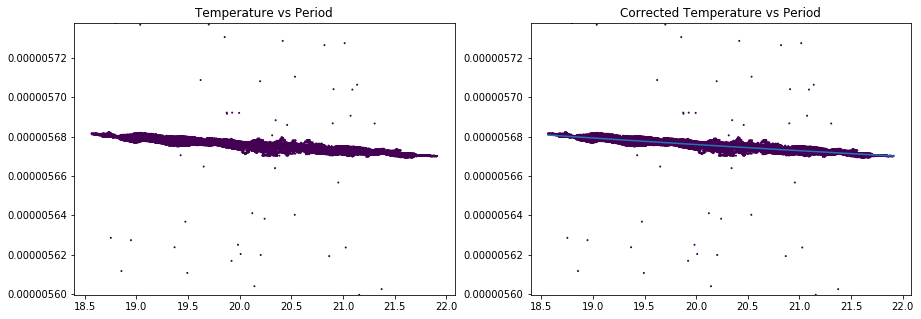

[ 2.27274250e-06 -1.07827290e-03  3.44970534e-06]


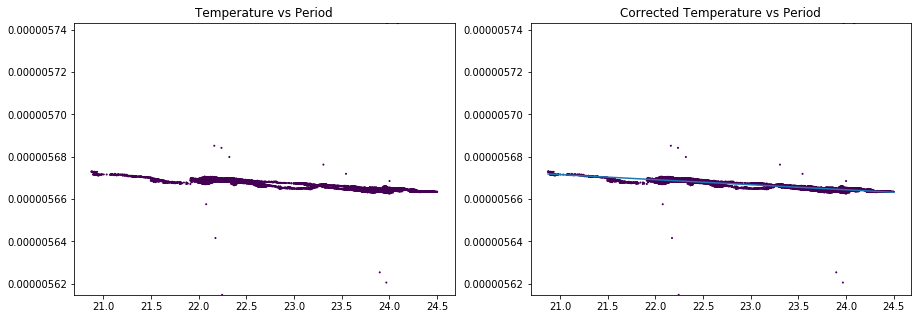

[ 3.86441806e-06 -1.00824219e-03  1.88855461e-06]


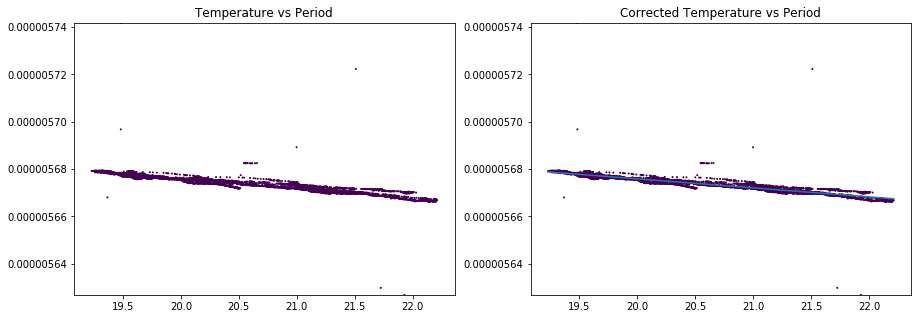

[ 1.98202395e-07 -4.29401569e-02  5.60147148e-06]


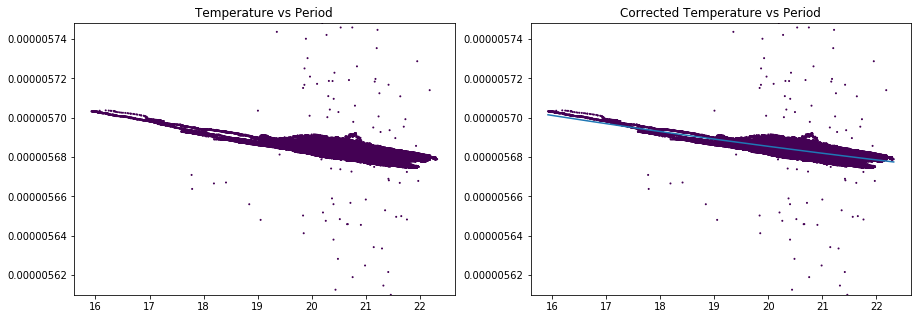

[ 2.56786999e-07 -5.38633119e-02  5.64582581e-06]


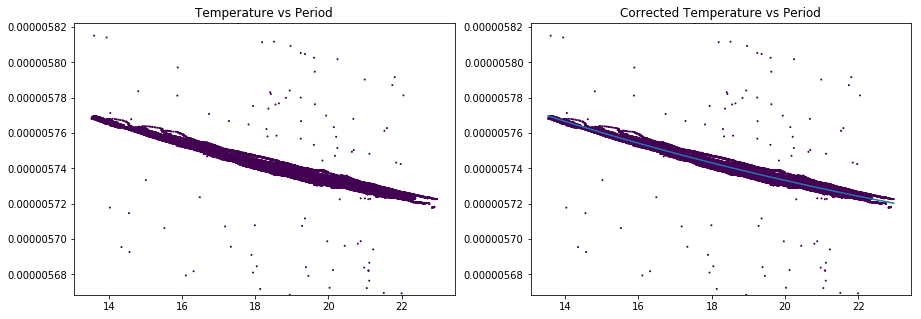

Expected n_samples >= n_components but got n_components = 2, n_samples = 1
[ 2.09530781e-06 -1.00000000e-02  4.55426180e-06]


/home/james/anaconda3/envs/anacenv/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


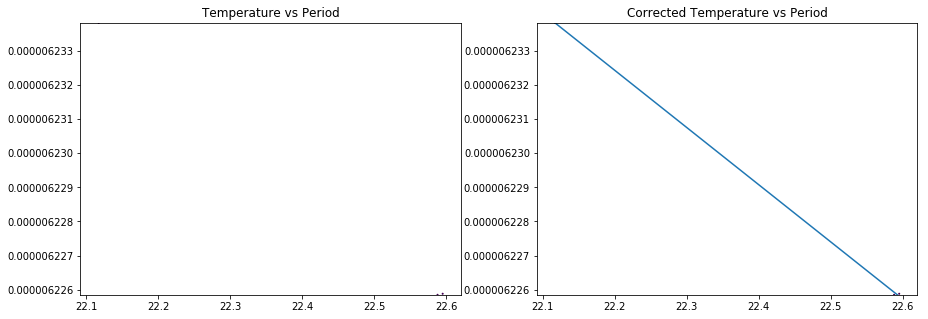

[ 1.01101137e-20 -2.44443840e-03  5.54785093e-06]


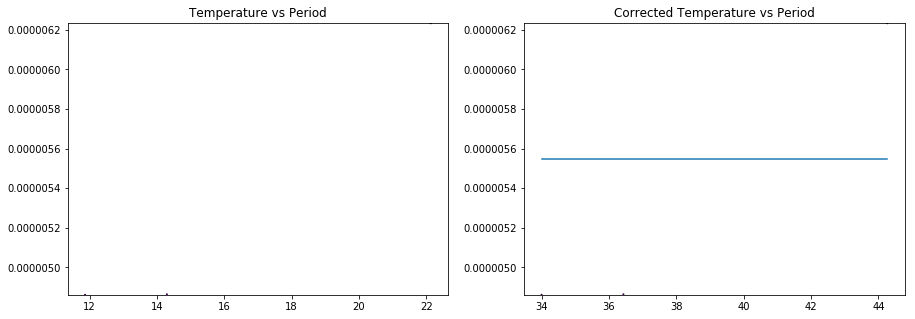

[ 9.99999804e+05 -1.49134621e+00  6.22627203e-06]


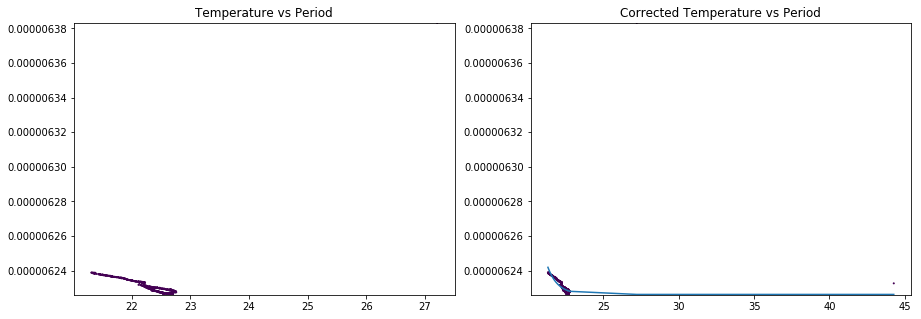

[ 4.07290608e-05 -1.43925332e-04 -3.41622824e-05]


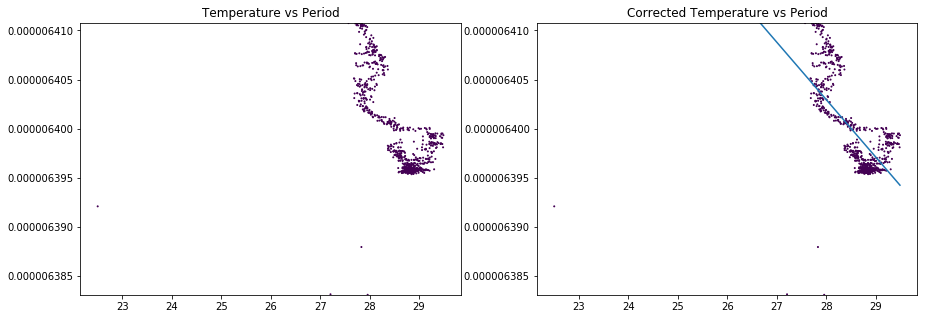

[ 5.86438239e-06 -9.98810569e-03  1.72194205e-06]


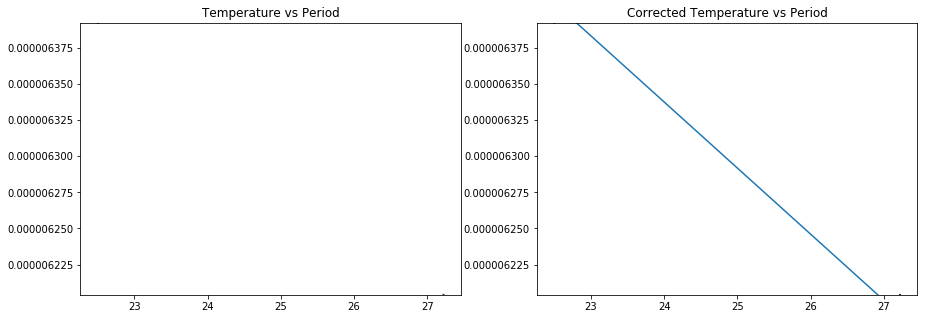

[ 5.36884658e-05 -1.17209749e-04 -4.73109642e-05]


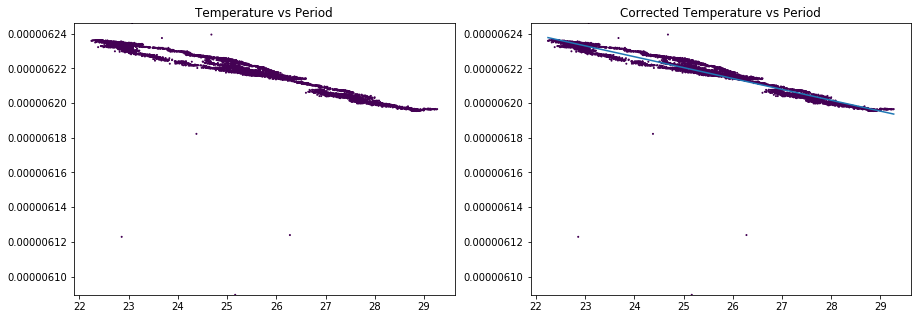

[ 4.76797175e-07 -2.96003682e-02  6.28927840e-06]


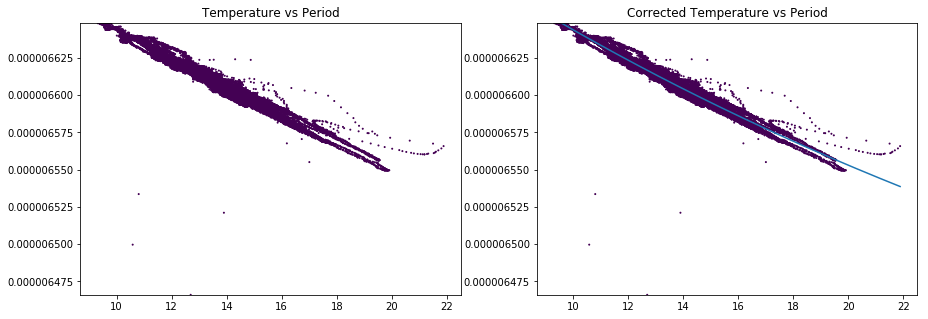

[ 9.99988668e+05 -2.09795743e+00  6.57702967e-06]


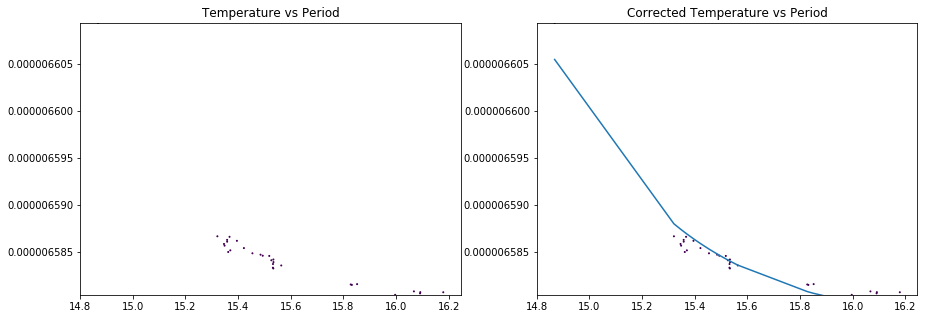

[ 5.00456094e-07 -6.77728923e-02  6.42091890e-06]


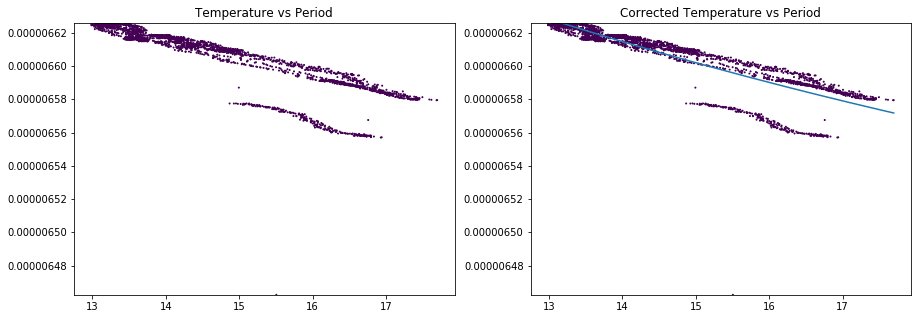

[ 5.17163599e-07 -3.16121471e-02  6.28609340e-06]


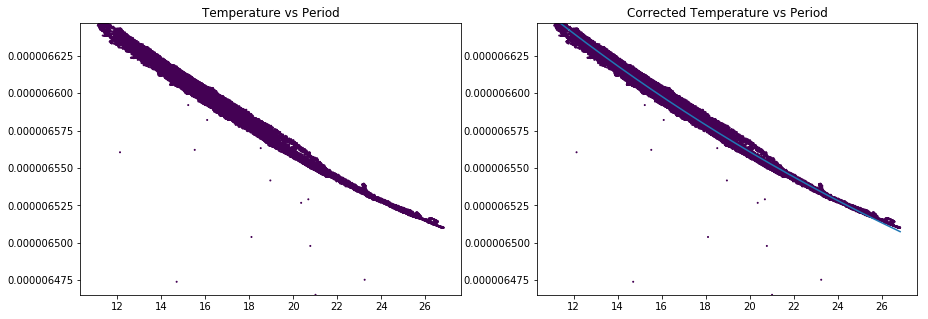

[ 4.12871956e-07 -6.24491520e-02  6.44201450e-06]


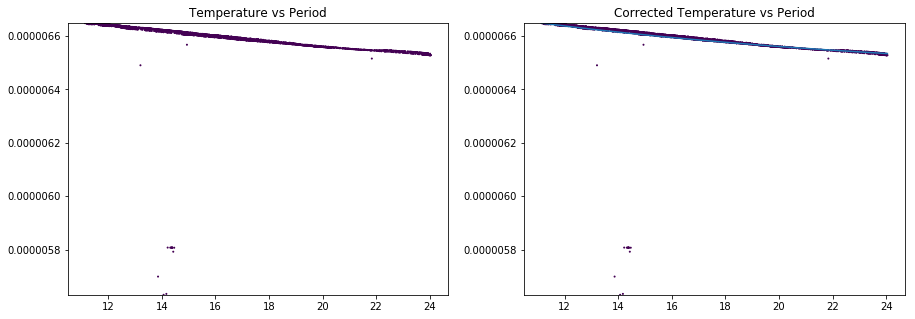

[ 3.55920294e-07 -2.86185048e-02  5.56780286e-06]


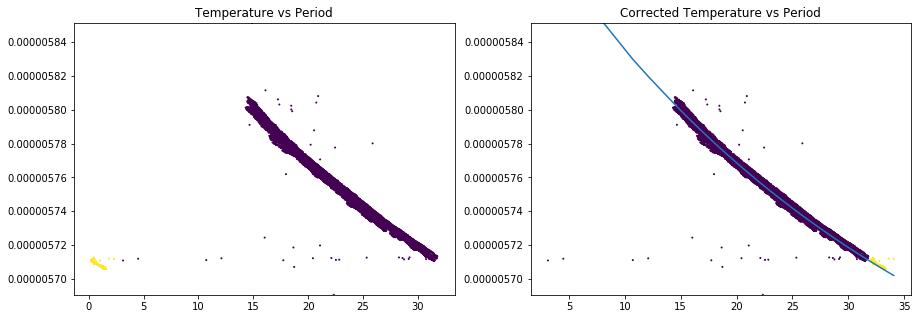

[ 3.51408655e-07 -5.41376193e-02  5.66193082e-06]


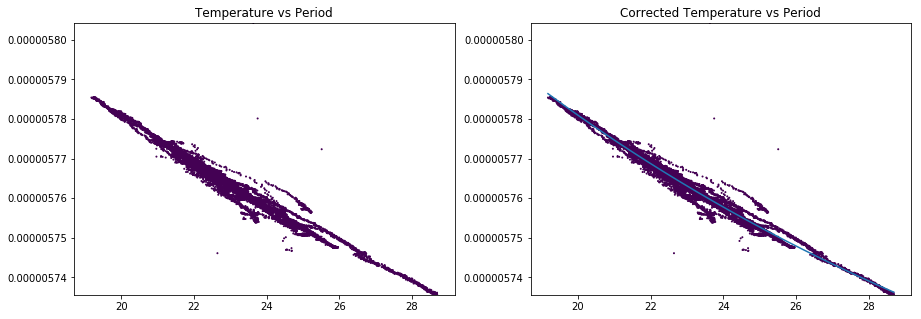

[ 2.96429476e-07 -4.22925795e-02  5.64896459e-06]


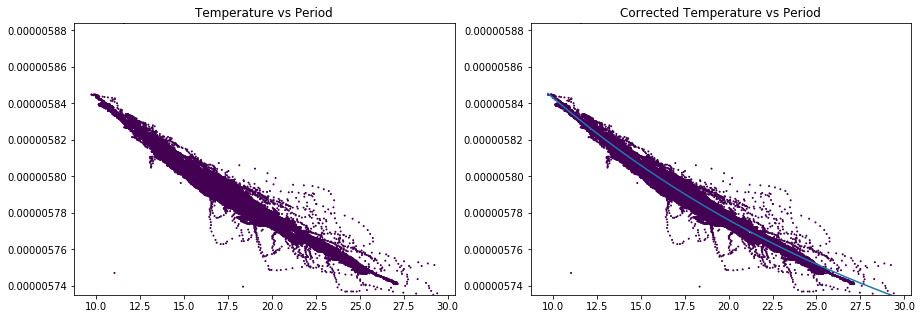

[ 3.27969468e-07 -3.33227356e-02  5.59602915e-06]


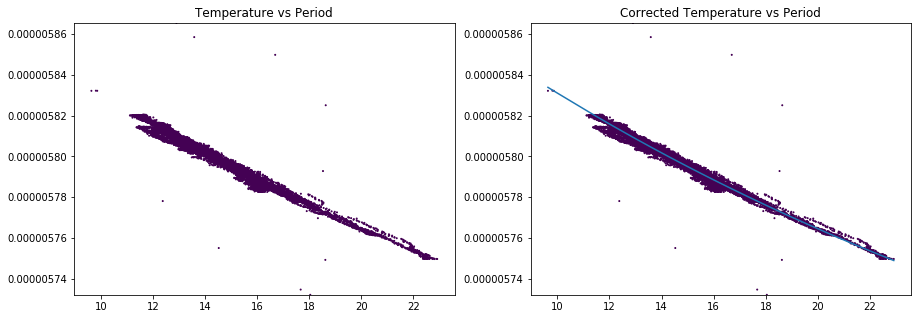

[ 2.97791962e-07 -4.24341013e-02  5.63300575e-06]


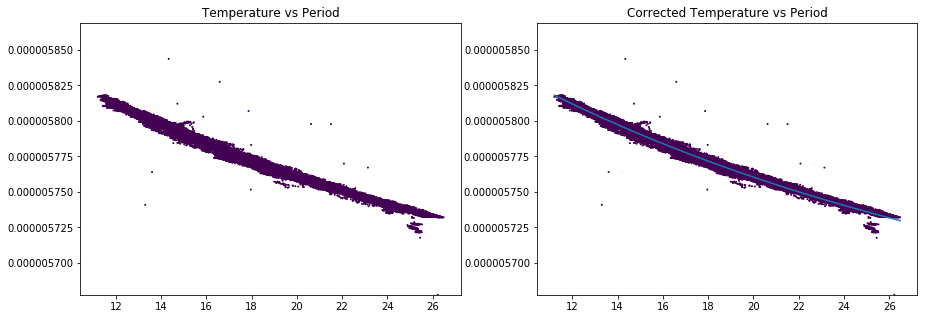

[ 4.71688938e-07 -1.35559364e-02  5.40939322e-06]


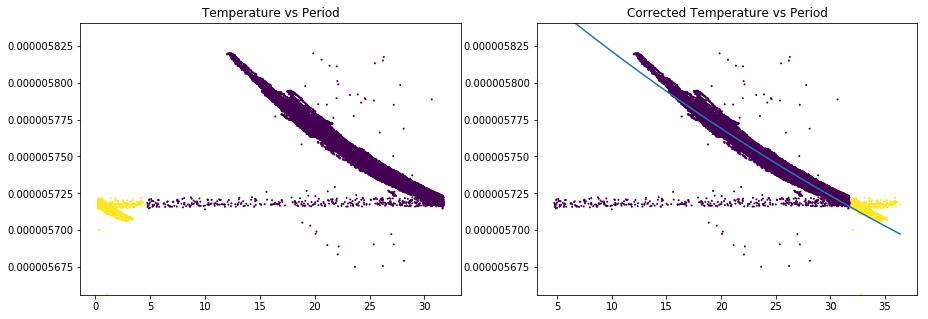

[ 3.23249269e-05 -1.15443748e-04 -2.64926781e-05]


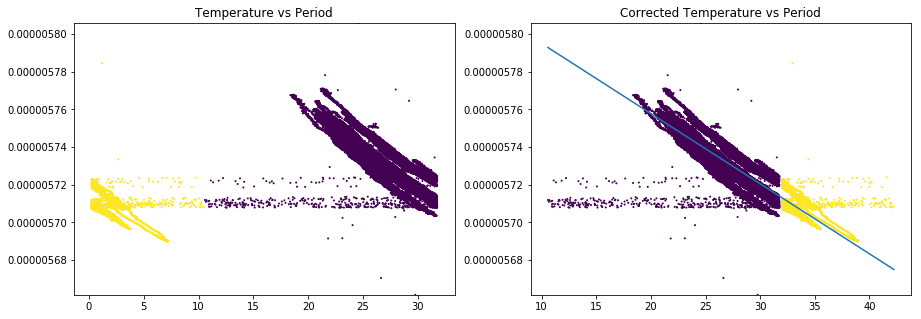

[ 7.51615066e-07 -4.99544093e-03  4.88150238e-06]


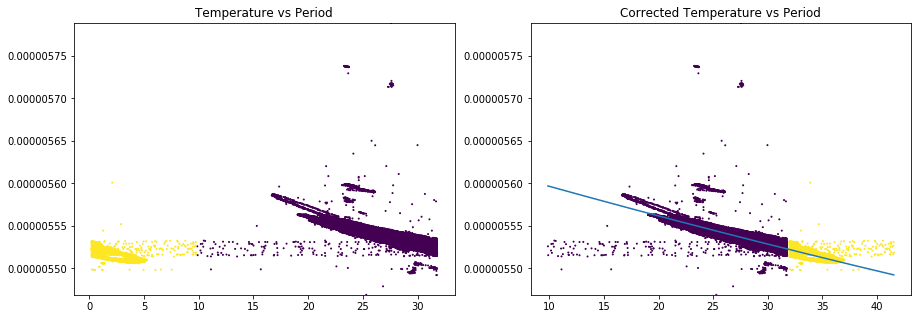

[ 2.08270717e-07 -9.00249184e-02  5.49795370e-06]


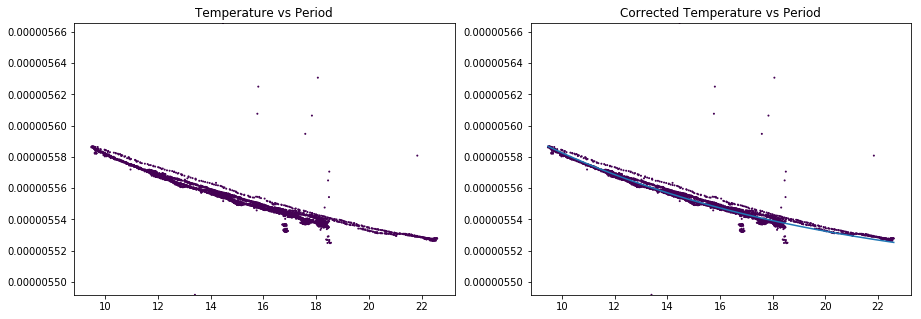

[ 4.15467479e-07 -1.57405784e-02  5.22507275e-06]


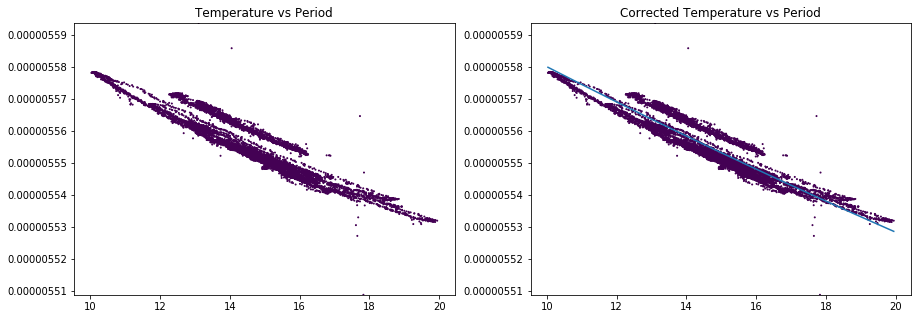

[ 2.27439604e-07 -8.56895015e-02  5.49083432e-06]


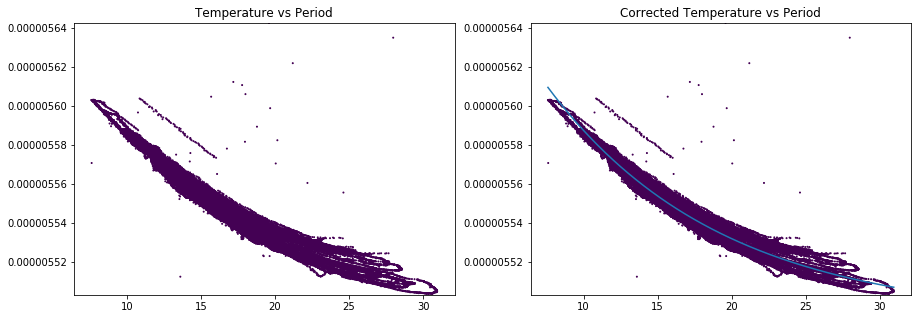

[ 1.87907889e-07 -3.60805658e-02  5.43692207e-06]


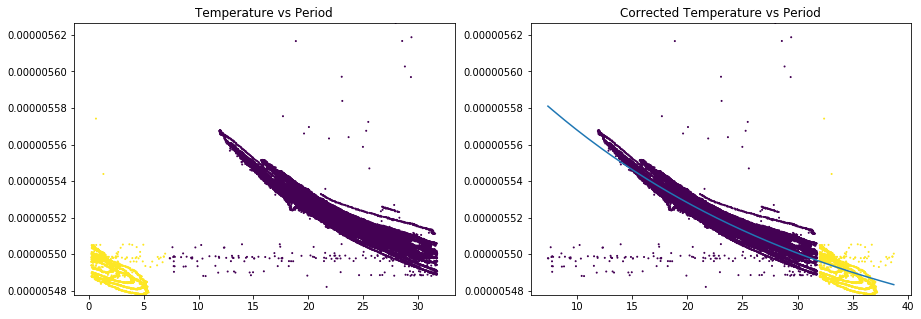

[ 4.36491636e-07 -9.98821313e-03  5.17149198e-06]


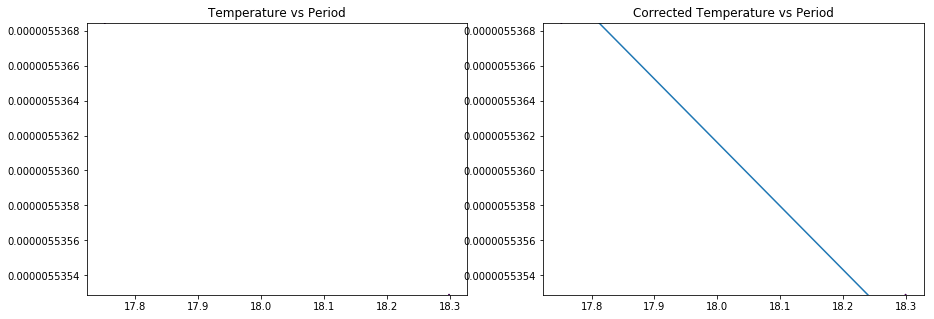

[ 9.38374514e-06 -8.92276985e-04 -3.69418278e-06]


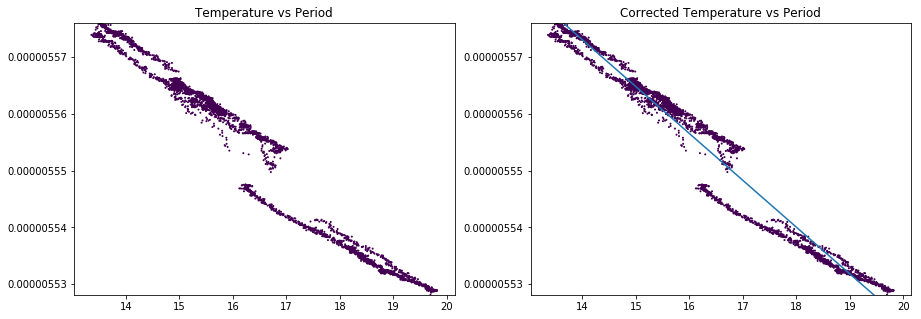

[ 2.57797438e-07 -5.88145961e-02  5.45349860e-06]


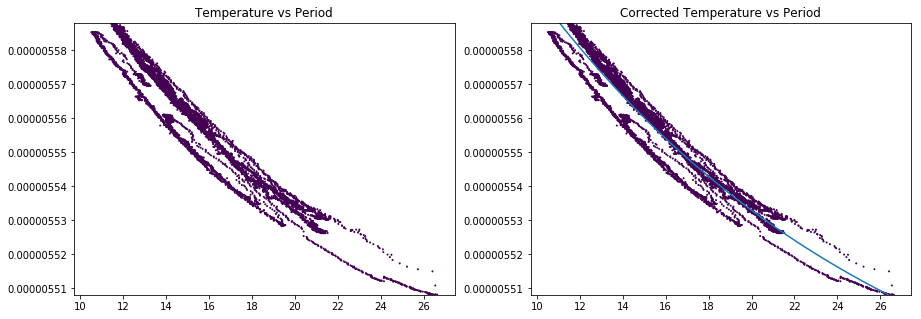

[ 5.83225454e-07 -8.90642026e-03  5.03869807e-06]


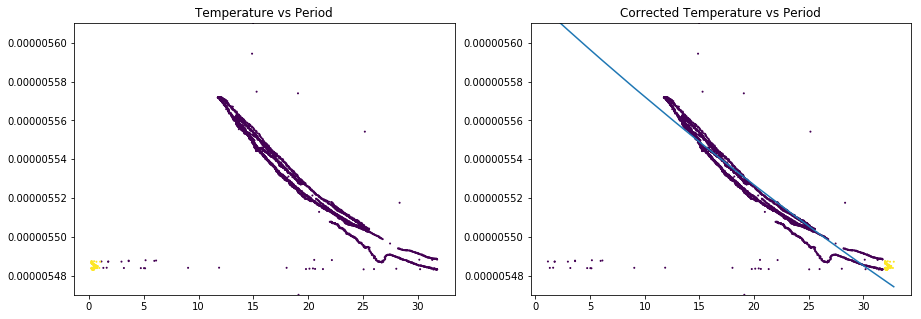

[ 2.17563908e-07 -4.27756453e-02  5.43018668e-06]


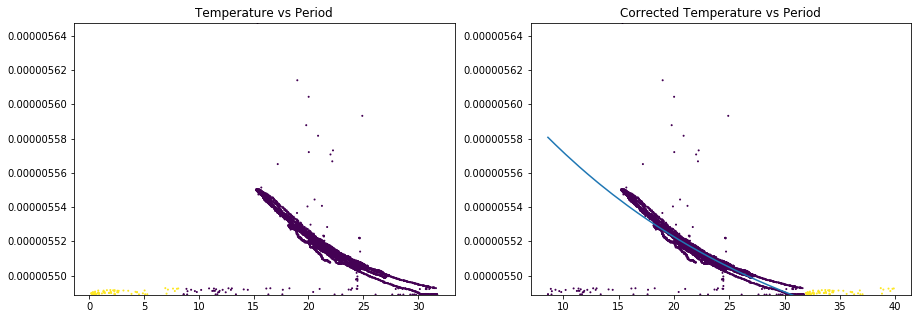

[ 3.17357105e-07 -9.29244291e-02  5.47175087e-06]


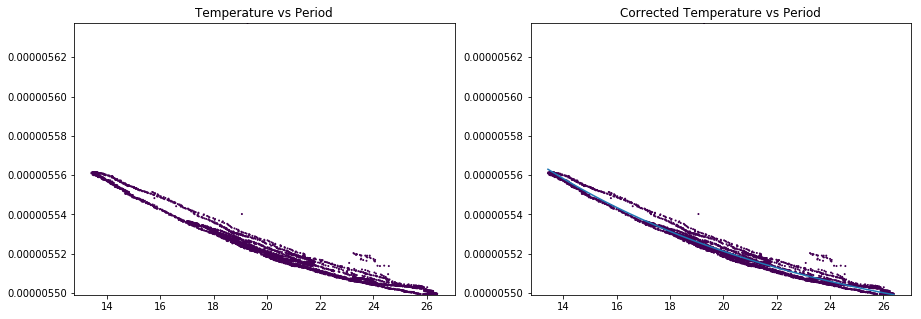

[ 2.31082676e-07 -3.55620761e-02  5.40359539e-06]


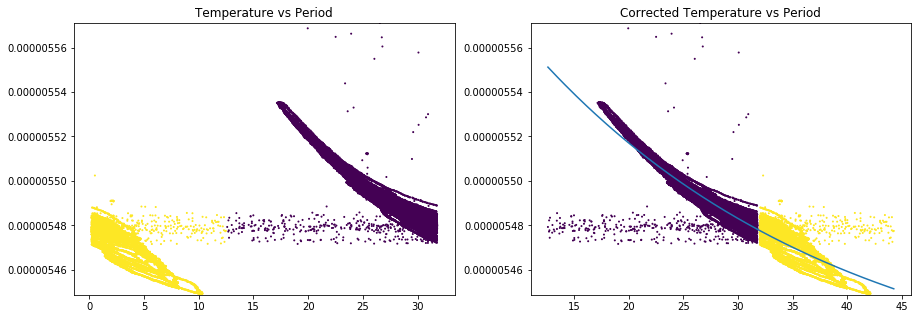

[ 5.28229161e-07 -1.14714412e-01  5.46640860e-06]


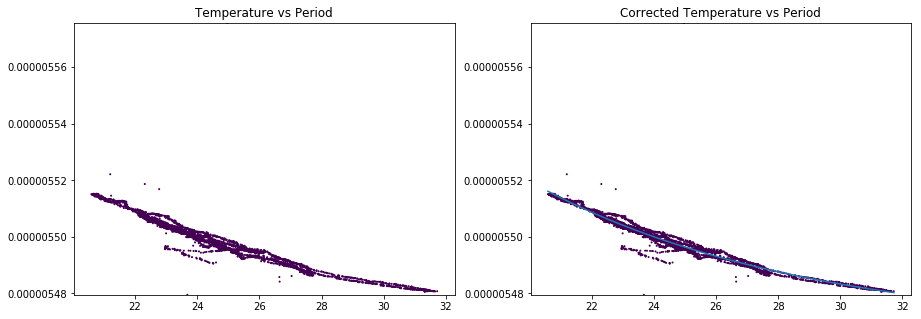

[ 5.15790277e-07 -1.16689446e-01  5.46355606e-06]


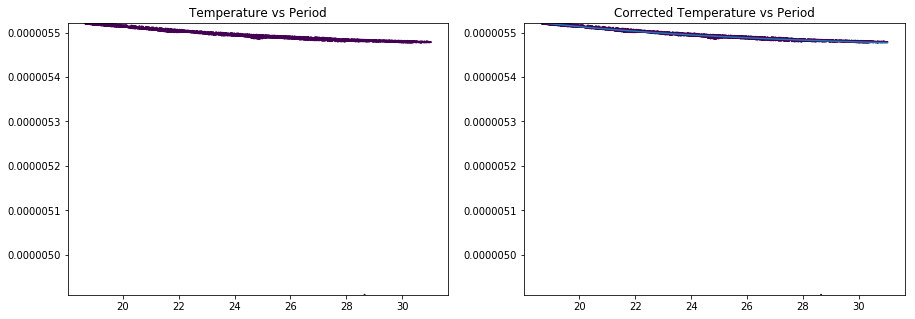

[ 4.18098987e-17 -8.33286846e-03  4.92466968e-06]


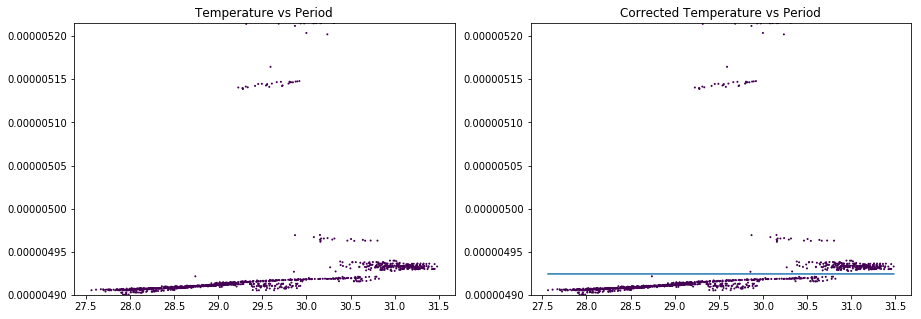

[ 1.65085329e-06 -5.79450734e-04  3.52538320e-06]


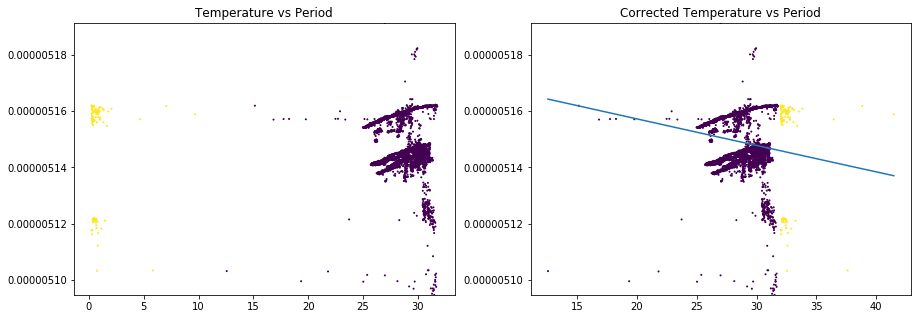

[ 5.36725974e-05 -1.44743295e-04 -4.71461470e-05]


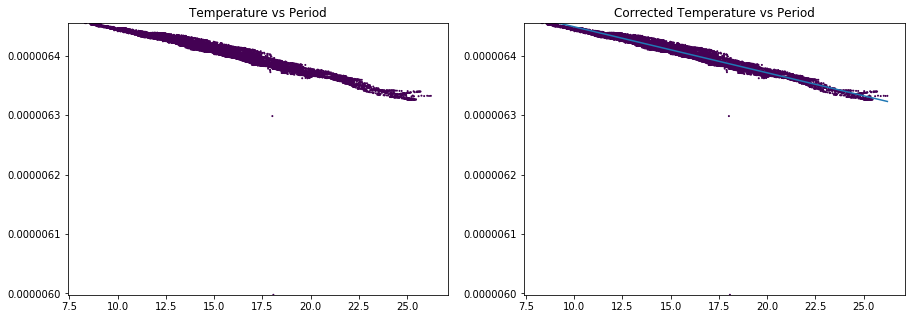

[ 2.06226719e-04 -3.73325518e-05 -1.99702258e-04]


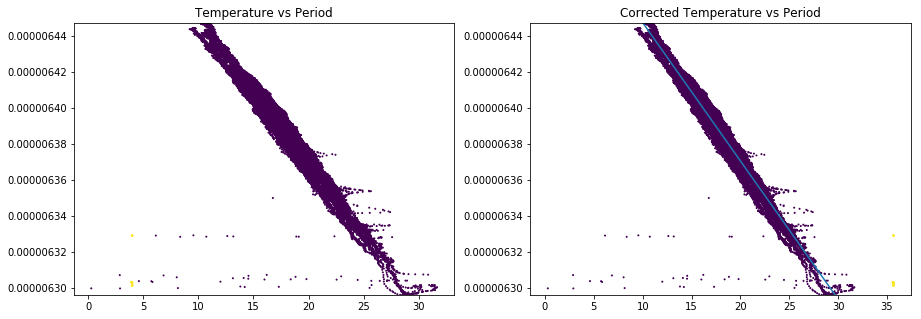

[ 1.89567103e-04 -3.85372227e-05 -1.83049782e-04]


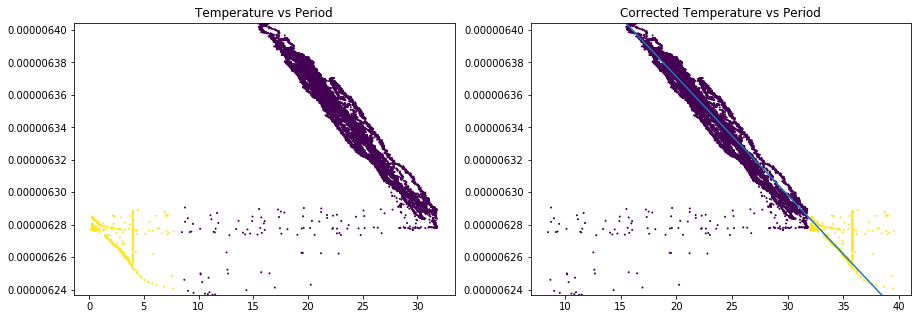

[ 6.34199650e-05 -1.25846165e-04 -5.68818897e-05]


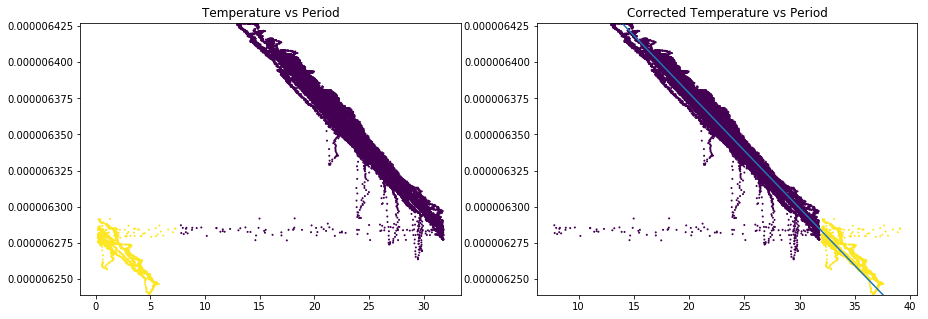

[ 4.98134711e-07 -4.42172421e-02  6.17499328e-06]


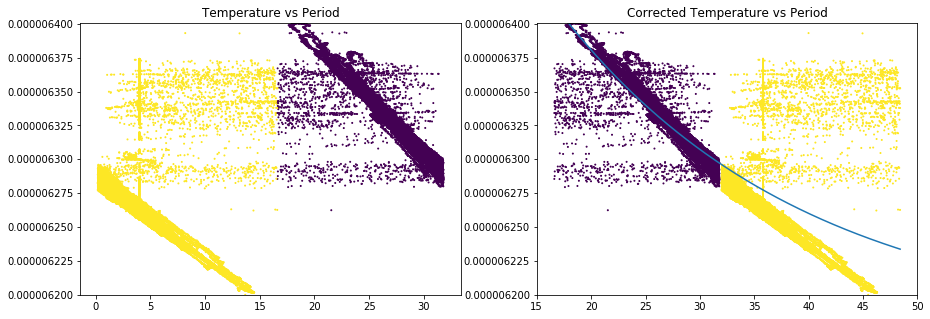

In [57]:
for i in range(split_times.shape[0] - 1):
    try:
        all_mag_dat.loc[split_times[i]:split_times[i+1]] = get_mag_field(all_mag_dat.loc[split_times[i]:split_times[i+1]])   
    except (ValueError, TypeError, RuntimeError) as e:
        print(e)

### Plot the variameter data.

Below, all the variameter data and the data for the 20/03/2016 is plotted. Note that erroneous values ($ \pm 1000nT+ $) are present. It may be worth considering removing these.

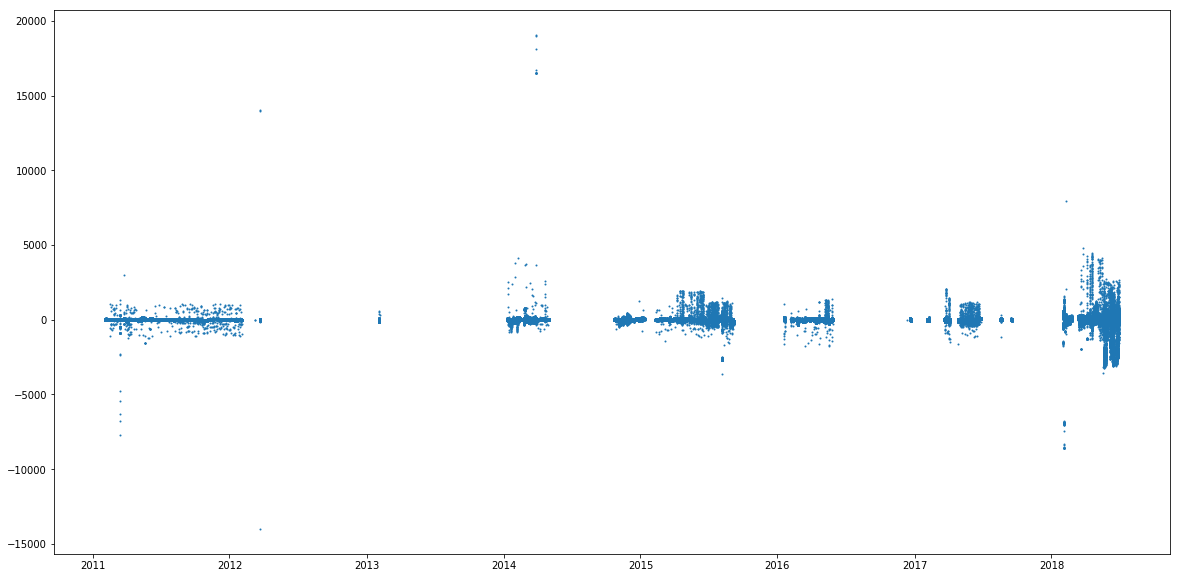

In [58]:
plt.figure(figsize=(20,10))
plt.plot(all_mag_dat["mag_field"], 'o', ms=1)
# all_mag_dat["mag_field"].unique()

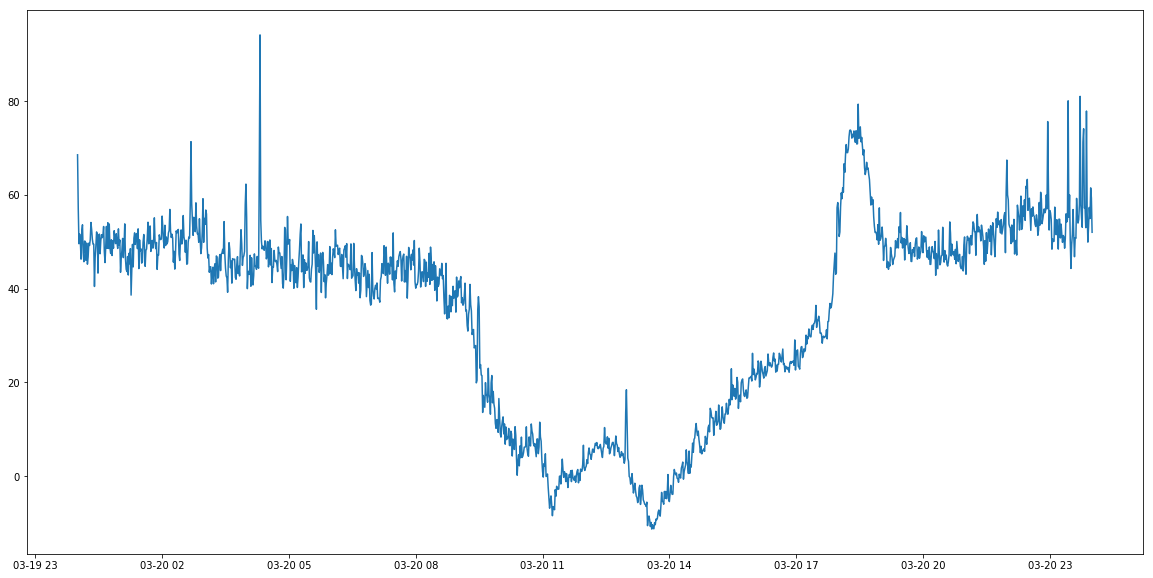

In [63]:
magfield_1h = all_mag_dat
win = magfield_1h.loc[np.datetime64('2016-03-20'):np.datetime64('2016-03-21')]
plt.figure(figsize=(20,10))
plt.plot(win["mag_field"])

### Including IGRF data with magnetometer readings.
WIP

### References

\[1\] T. Zagidulin, *REPORT ON FG 3+ FLUXGATE SENSORS TESTING*, 04/06/2018. \[Online\]. Available: https://docs.wixstatic.com/ugd/7034a0_5354433f024e4bbb9df2428c8c49afd0.pdf . Accessed: 16/08/2018